In [83]:
# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler

from torch import Tensor
import torch
import torch.nn as nn
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip '/content/drive/MyDrive/competition_1st/data.zip'

# EDA

## 변수 설명
  - **int_rate** : 대출자에 부여된 이자율 (Interest rate of the loan the applicant received)
  - **annual_inc** : 연 소득 (annual income)
  - **dti** : 소득 대비 부채 비율 (Debt-to-income ratio)
  - **delinq_2yrs** : 지난 2년 간 체납 발생 횟수 (Delinquencies on lines of credit in the last 2 years)
  - **inq_last_6mths** : 지난 6개월 간 신용 조회 수 (Inquiries into the applicant's credit during the last 6 months)
  - **pub_rec** : 파산 횟수 (Number of bankruptcies listed in the public record)
  - **revol_bal** : 리볼빙 잔액 (Total credit revolving balance)
  - **total_acc** : 지금까지 소유했던 신용카드 개수 (num_total_cc_accounts : Total number of credit card accounts in the applicant's history)
  - **collections_12_mths_ex_med** : 의료부문을 제외한 지난 12개월 간 추심 발생 횟수 (num_collections_last_12m : Number of collections in the last 12 months. This excludes medical collections)
  - **acc_now_delinq** : 대출자가 체납 상태에 있지 않은 계좌의 수 (The number of accounts on which the borrower is now delinquent)
  - **tot_coll_amt** : 대출자에 대한 현재까지의 총 추심액 (total_collection_amount_ever : The total amount that the applicant has had against them in collections)
  - **tot_cur_bal** : 전 계좌의 현재 통합 잔고 (Total current balance of all accounts)
  - **chargeoff_within_12_mths** : 대출 부 신청인의 대출 신청 직전 12개월 간 세금 공제 횟수 (Number of charge-offs within last 12 months at time of application for the secondary applicant)
  - **delinq_amnt** : 체납 금액 (delinquency amount)
  - **tax_liens** : 세금 저당권의 수 (Number of tax liens)
  - **emp_length1 ~ 12** : 고용 연수 (Number of years in the job)
  - **home_ownership1 ~ 6** : 대출 신청자의 주거 소유 형태 (The ownership status of the applicant's residence)
  - **verification_status1 ~ 3** : 공동 소득 발생 여부 및 형태 (verification_income_joint : Type of verification of the joint income)
  - **purpose1 ~ 14** : 대출 목적 (The purpose of the loan)
  - **initial_list_status1 ~ 2** : 최초 대출 상태 (Initial listing status of the loan)
  - **mths_since_last_delinq1 ~ 11** : 마지막 체납이 지금으로부터 몇개월 전에 있었는지를 나타내는 변수 (Months since the last delinquency)
  
  - **funded_amnt** : 대출액 (Funded amount)
  - **funded_amnt_inv** : 사채 대출액 (Funded amount by investors)
  - **total_rec_late_fee** : 총 연체료 중 납부액 (Late fees received to date)
  - **term1** : 상환 기간 (The number of payments on the loan. Values are in months and can be either 36 or 60)
  - **open_acc** : 개설 개좌 수 (The number of open credit lines in the borrower's credit file)
  - **installment** : 대출 발생 시 월 상환액 (The monthly payment owed by the borrower if the loan originates)
  - **revol_util** : 리볼빙 한도 대비 리볼빙 사용 비율 (Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit)
  - **out_prncp** : 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded)
  - **out_prncp_inv** : 사채 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded by investors)
  - **total_rec_int** : 이자 상환액 (Interest received to date)
  - **fico_range_low** : FICO(일종의 신용점수) 최저값 (The lower boundary range the borrower’s FICO at loan origination belongs to)
  - **fico_range_high** : FICO(일종의 신용점수) 최고값 (The upper boundary range the borrower’s FICO at loan origination belongs to)
  
  - **depvar** : 고객의 부도 여부 (dependent variable)

In [2]:
df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')

In [3]:
# df.info()

In [4]:
# df.describe()

In [6]:
# 결측치 확인
# pd.DataFrame(df.isnull().sum()).rename(columns={0:'Non-Null Count'}).T

In [5]:
# 라벨(depvar) 비율 확인
print('y=1 ratio :', df.depvar.sum()/len(df))

y=1 ratio : 0.32569


### 의사결정나무 특징 중요도 파악

In [7]:
dcs_tree_clf = DecisionTreeClassifier(random_state=0)
dcs_tree_clf.fit(df.drop(columns=['depvar']), df['depvar'])
dcs_tree_clf.score(df.drop(columns=['depvar']), df['depvar'])

1.0

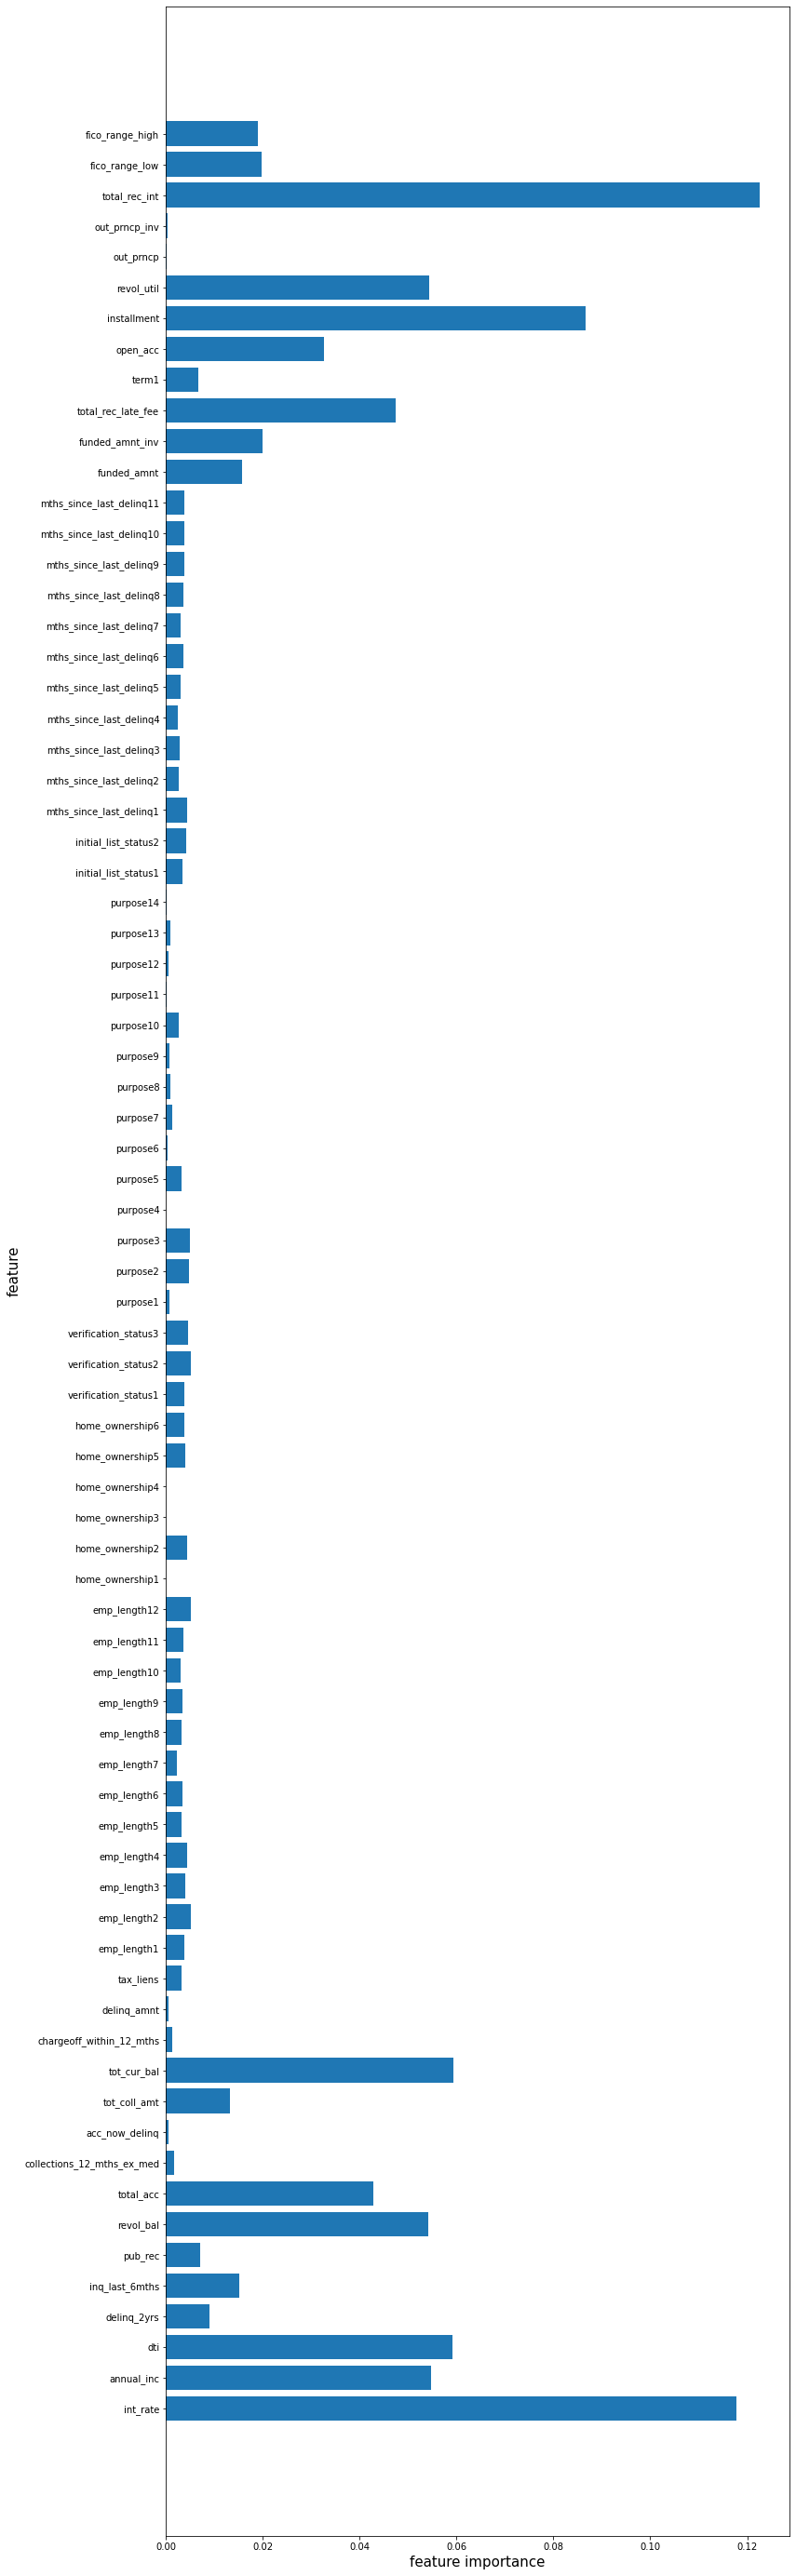

In [10]:
feature_imp = dcs_tree_clf.feature_importances_
idx = np.arange(len(df.drop(columns=['depvar']).columns))

plt.figure(figsize=(12, 50))
plt.barh(idx, feature_imp, align='center')
plt.yticks(idx, df.drop(columns=['depvar']).columns)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

In [75]:
print(len(feature_imp)) # 특징 갯수
print(type(feature_imp))
print(sum(feature_imp))
print(1/75) # 0.015 이하는 버릴 예정

75
<class 'numpy.ndarray'>
1.0000000000000004
0.013333333333333334


In [76]:
for_del_idx = [i if (_<0.015) else None for i, _ in enumerate(feature_imp)]
print(for_del_idx)
extract_del_idx = list()
for i in for_del_idx:
  if i is not None:
    extract_del_idx.append(i)
print(extract_del_idx)

[None, None, None, 3, None, 5, None, None, 8, 9, 10, None, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, None, None, None, 66, None, None, None, 70, 71, None, None, None]
[3, 5, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 66, 70, 71]


In [101]:
# col_list = df.drop(columns=['depvar']).columns
# print(col_list)
# print(type(col_list))

In [77]:
# columns가 pandas타입이라서 list형태로 바꿔준다
col_list = list(df.drop(columns=['depvar']).columns)

In [78]:
extract_del_idx.reverse()
print(extract_del_idx)

[71, 70, 66, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 10, 9, 8, 5, 3]


In [79]:
proc_col = list()
for i in extract_del_idx:
  del col_list[i]
  
proc_col = col_list
print(proc_col)  # 관리할 columns들

['int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'revol_bal', 'total_acc', 'tot_cur_bal', 'funded_amnt', 'funded_amnt_inv', 'total_rec_late_fee', 'open_acc', 'installment', 'revol_util', 'total_rec_int', 'fico_range_low', 'fico_range_high']


In [80]:
df2 = df[proc_col]
df2.head()

,int_rate,annual_inc,dti,inq_last_6mths,revol_bal,total_acc,tot_cur_bal,funded_amnt,funded_amnt_inv,total_rec_late_fee,open_acc,installment,revol_util,total_rec_int,fico_range_low,fico_range_high
0,0.0824,21000.0,29.19,1,3016,26,11773,1200,1200.0,0.0,18,37.74,0.076,157.94,765,769
1,0.1299,80000.0,4.82,1,5722,24,21875,8000,8000.0,0.0,8,269.52,0.447,1702.42,665,669
2,0.1299,38000.0,23.66,3,6511,18,31868,5000,5000.0,0.0,7,168.45,0.880,1066.64,670,674
3,0.1367,100000.0,16.27,2,6849,30,326049,15000,15000.0,0.0,12,510.27,0.457,1256.24,680,684
4,0.1269,30000.0,25.28,1,8197,12,8840,10000,10000.0,0.0,8,335.45,0.416,871.04,660,664


### 추출된 features
- **int_rate** : 대출자에 부여된 이자율
- **annual_inc** : 연 소득 (annual income)
- **dti** : 소득 대비 부채 비율
- **inq_last_6mths** : 지난 6개월 간 신용 조회 수 X
- **revol_bal** : 리볼빙 잔액
- **total_acc** : 지금까지 소유했던 신용카드 개수
- **tot_cur_bal** : 전 계좌의 현재 통합 잔고
- **funded_amnt** : 대출액 (Funded amount)
- **funded_amnt_inv** : 사채 대출액
- **total_rec_late_fee** : 총 연체료 중 납부액
- **open_acc** : 개설 개좌 수
- **installment** : 대출 발생 시 월 상환액
- **revol_util** : 리볼빙 한도 대비 리볼빙 사용 비율
- **total_rec_int** : 이자 상환액
- **fico_range_low** : FICO(일종의 신용점수) 최저값 
- **fico_range_high** : FICO(일종의 신용점수) 최고값



# Train Valid Split

In [88]:
X = df.drop('depvar', axis=1)
y = df['depvar']

In [98]:
# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [90]:
# training set과 validation set의 데이터 수 확인
print('training set length :', len(X_train))
print('validation set length :', len(X_valid))

training set length : 80000
validation set length : 20000


In [91]:
# validation set의 라벨 비율 확인
y_valid.sum()/len(y_valid)

0.32525

In [99]:
# 정규화합니다
scaler = StandardScaler()
X_train = torch.FloatTensor(scaler.fit_transform(X_train.to_numpy()))
y_train = torch.LongTensor(y_train.to_numpy())

tensor([[ 0.2016,  0.0494,  0.4906,  ...,  2.1001, -0.9319, -0.9319],
        [ 0.1993,  0.0100, -1.9555,  ...,  0.0969, -0.5941, -0.5941],
        [ 0.4966, -0.3319,  0.8114,  ..., -0.5851, -0.7630, -0.7630],
        ...,
        [ 0.2016, -0.4840,  0.8684,  ..., -0.7505, -0.9319, -0.9319],
        [-0.1337,  0.9963, -0.7081,  ...,  0.5435, -0.5941, -0.5941],
        [ 0.5592, -0.4503,  1.7558,  ..., -0.5230, -0.9319, -0.9319]])

80000